In [98]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [ ]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)
data_france_sample = data_france.sample(frac=.1)

In [5]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands.sample(frac=.1)

In [ ]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

## Experiments

### Prediction error leads to single peak distribution of predicted age

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


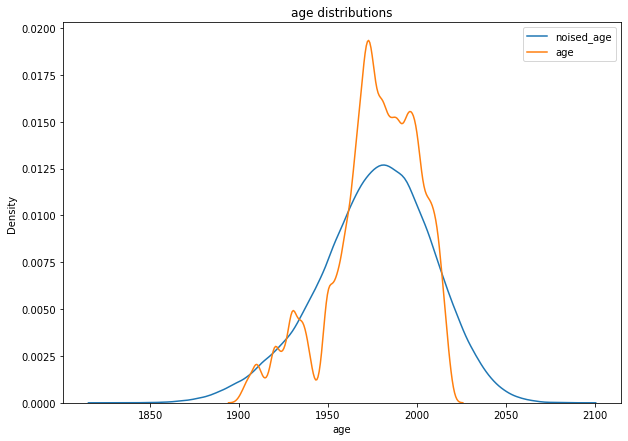

In [57]:

df = remove_outliers(data_netherlands_sample)
# df = remove_buildings_between_1930_1990(df)

RMSE = 21
noise = np.random.normal(scale=RMSE, size=len(df))
df['noised_age'] = df[dataset.AGE_ATTRIBUTE] + noise

visualizations.plot_distribution({'noised_age': df['noised_age'], 'age': df[dataset.AGE_ATTRIBUTE]})

2022-01-18 18:50:55,856 | INFO : Dataset length: 147536
2022-01-18 18:50:55,997 | INFO : Test dataset length: 29508
2022-01-18 18:50:55,997 | INFO : Training dataset length: 118028
2022-01-18 18:50:55,998 | INFO : Standard deviation of test set: 33.54870019457321
2022-01-18 18:50:56,130 | INFO : Test dataset length after preprocessing: 29353
2022-01-18 18:50:56,131 | INFO : Training dataset length after preprocessing: 117420
2022-01-18 18:50:56,132 | INFO : Standard deviation of test set after preprocessing: 28.12385297466674


MAE: 14.385166386414665 y
RMSE: 21.317442278135438 y
R2: 0.4254400506592555


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


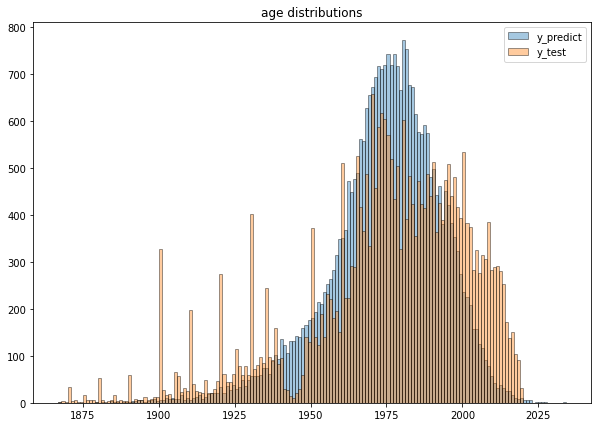

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

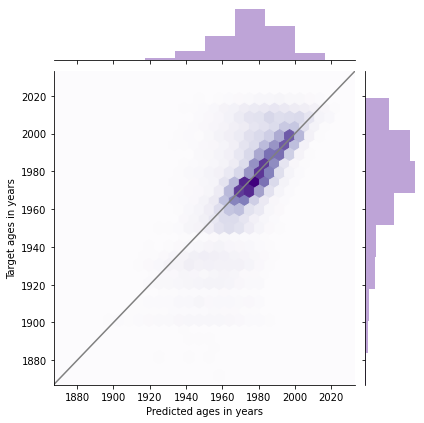

invalid value encountered in true_divide


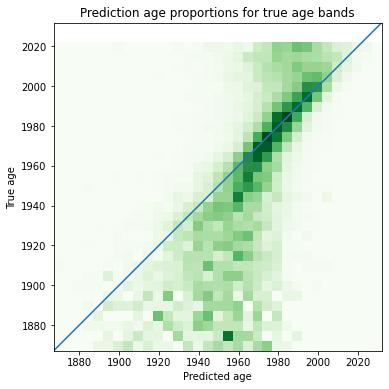

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


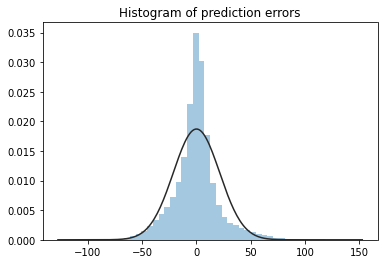

Excess kurtosis of normal distribution (should be 0): [3.56314157]
Skewness of normal distribution (should be 0): [0.61602482]


In [107]:
from scipy.stats import norm

predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1850, remove_other_attributes]
)
predictor.evaluate_regression()
mu, std = norm.fit(predictor.y_test - predictor.y_predict)

visualizations.plot_prediction_error_histogram(predictor.y_test, predictor.y_predict)

### Removing buildings from certain age bands

2022-01-18 09:57:45,176 | INFO : Dataset length: 147536
2022-01-18 09:57:45,304 | INFO : Test dataset length: 29508
2022-01-18 09:57:45,305 | INFO : Training dataset length: 118028
2022-01-18 09:57:45,306 | INFO : Standard deviation of test set: 33.54870019457321
2022-01-18 09:57:45,521 | INFO : Test dataset length after preprocessing: 11507
2022-01-18 09:57:45,522 | INFO : Training dataset length after preprocessing: 45824
2022-01-18 09:57:45,523 | INFO : Standard deviation of test set after preprocessing: 39.29281480673599


MAE: 18.227721632246947 y
RMSE: 28.19564615332198 y
R2: 0.48503754795803633


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


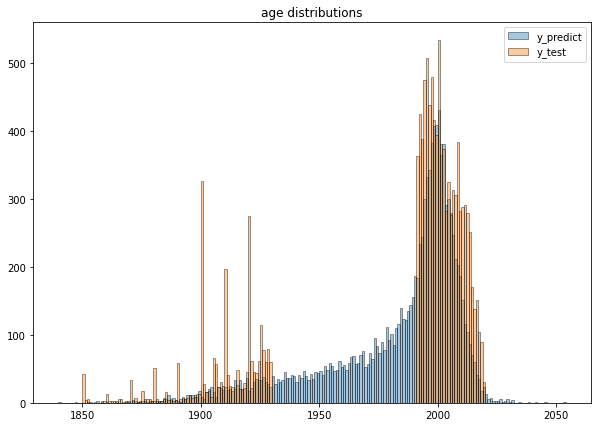

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

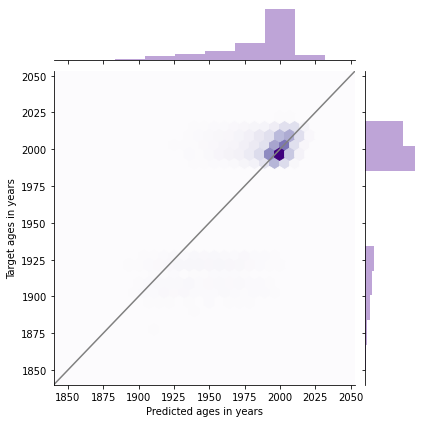

invalid value encountered in true_divide


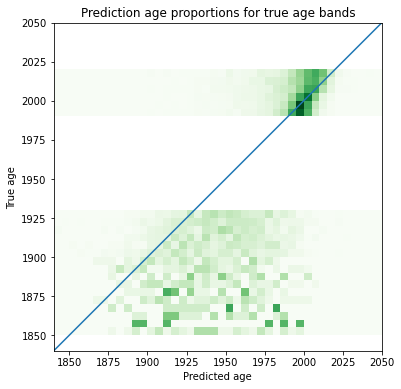

In [8]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1850, remove_buildings_between_1930_1990, remove_other_attributes]
)
predictor.evaluate_regression()

### Transformation of age variable to mitigate skewness of prediction error

overflow encountered in multiply
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


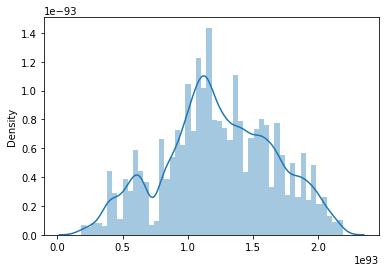

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


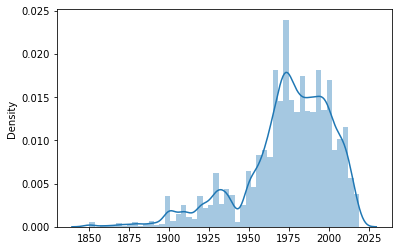

In [54]:
from scipy.special import inv_boxcox
from scipy.stats import boxcox
sample_transformed, lambd = boxcox(predictor.y_test['age'])
sns.distplot(sample_transformed)
plt.show()
reversed = inv_boxcox(sample_transformed, lambd)
sns.distplot(reversed)
plt.show()


In [78]:
df = data_netherlands_sample.copy()
df.dropna(subset=[dataset.AGE_ATTRIBUTE], inplace=True)
df.drop_duplicates(subset=['id'], inplace=True)
df = df[df[dataset.AGE_ATTRIBUTE] >= 1850]

age_transformed, lambd = boxcox(df[dataset.AGE_ATTRIBUTE])

df[dataset.AGE_ATTRIBUTE] = age_transformed / 1e90 # to prevent overflow

predictor_transformed = AgePredictor(
    model=XGBRegressor(),
    df=df,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_other_attributes]
)


overflow encountered in multiply
overflow encountered in reduce
2022-01-18 12:41:22,260 | INFO : Dataset length: 146773
2022-01-18 12:41:22,388 | INFO : Test dataset length: 29355
2022-01-18 12:41:22,389 | INFO : Training dataset length: 117418
2022-01-18 12:41:22,390 | INFO : Standard deviation of test set: 47.22924314051748
2022-01-18 12:41:22,455 | INFO : Test dataset length after preprocessing: 29355
2022-01-18 12:41:22,456 | INFO : Training dataset length after preprocessing: 117418
2022-01-18 12:41:22,457 | INFO : Standard deviation of test set after preprocessing: 47.22924314051748


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


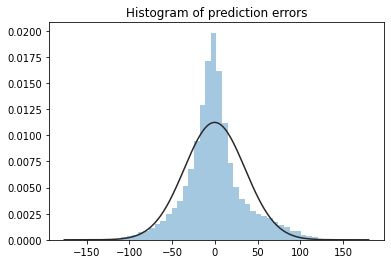

Excess kurtosis of normal distribution (should be 0): [1.55605058]
Skewness of normal distribution (should be 0): [0.35111879]
MAE: 25.15299993833879 y
RMSE: 35.5185297397129 y
R2: 0.4344086181385105


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


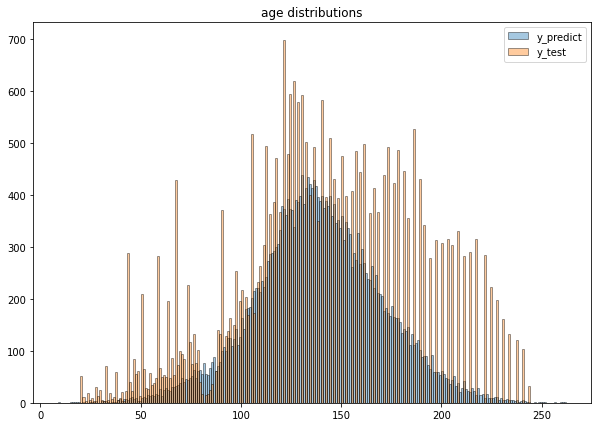

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

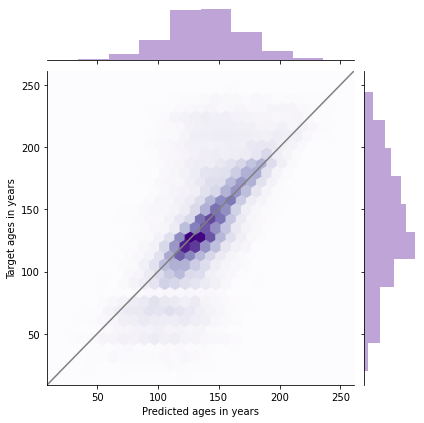

invalid value encountered in true_divide
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


MAE: 14.362868267080044 y
RMSE: 21.89941286967476 y
R2: 0.3989467340138191


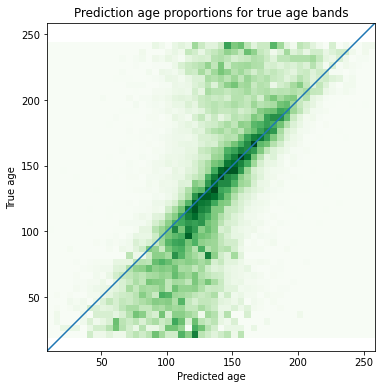

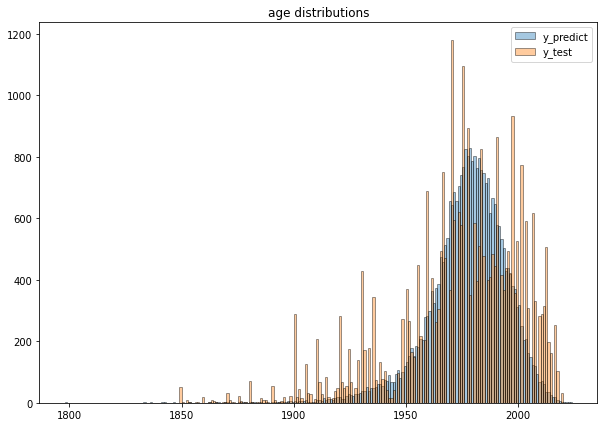

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

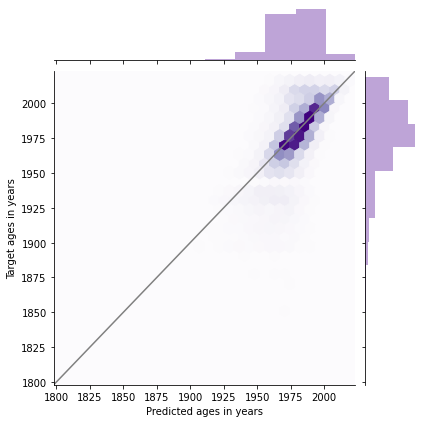

invalid value encountered in true_divide


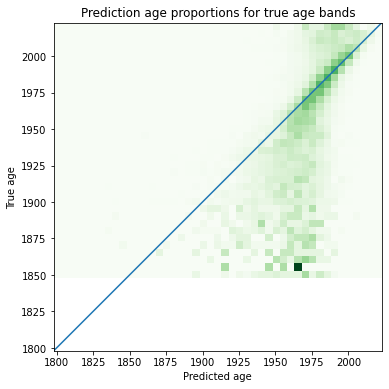

In [79]:
visualizations.plot_prediction_error_histogram(predictor_transformed.y_test, predictor_transformed.y_predict)
predictor_transformed.evaluate_regression()

predictor_transformed.y_test = inv_boxcox(predictor_transformed.y_test * 1e90, lambd)
predictor_transformed.y_predict = inv_boxcox(predictor_transformed.y_predict * 1e90, lambd)
predictor_transformed.evaluate_regression()